In [ ]:
!pip install scikit-multilearn

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import joblib

from sklearn import feature_extraction, tree, svm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from heapq import nlargest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Masters_Team_Project_Final/Binary_Classification/Evening_500Dataset.xlsx")
df.head()

,Count,Unnamed: 0,uid,startTime,record,evening_sentiment,evening_sent_score,text_ner,Final Label
0,1,18582.0,41327,2022-04-02T00:02:52.451000+00:00,evening,neutral,0.691588,Talked to [Named Entity]\nHad [Named Entity] f...,Cognitive Change
1,2,1686.0,98269,2023-12-13T03:26:10.324000+00:00,evening,neutral,0.590814,[Named Entity] [Named Entity]Resources for hea...,NaN
2,3,20115.0,35133,2022-02-26T03:07:26.958000+00:00,evening,neutral,0.890486,Connecting with [Named Entity] sometimes,NaN
3,4,6334.0,48538,2023-05-26T23:19:36.267000+00:00,evening,neutral,0.916070,[Named Entity] [Named Entity] [Named Entity]Lu...,NaN
4,5,31845.0,116521,2024-05-27T10:36:08.475000+00:00,evening,positive,0.976836,Present for [Named Entity] he really appreciat...,Situation Modification


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Count               500 non-null    int64  
 1   Unnamed: 0          400 non-null    float64
 2   uid                 500 non-null    int64  
 3   startTime           500 non-null    object 
 4   record              500 non-null    object 
 5   evening_sentiment   500 non-null    object 
 6   evening_sent_score  500 non-null    float64
 7   text_ner            498 non-null    object 
 8   Final Label         473 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 35.3+ KB


In [ ]:
# Remove any spaces from the 'Final Label' column values
df['Final Label'] = df['Final Label'].str.strip()

# Standardize the format by:
# - Splitting the values into a list using ', ' as a separator
# - Keeping NaN values and entries explicitly labeled as 'none' unchanged
df['Final Label'] = df['Final Label'].apply(
    lambda x: ', '.join(sorted(x.split(', '))) if pd.notnull(x) and x.lower() != 'none' else x
)

# Ensure consistent representation by replacing lowercase 'none' with 'None'
df['Final Label'] = df['Final Label'].replace('none', 'None')

# Count the occurrences of each unique category combination
df['Final Label'].value_counts()

,count
Final Label,
Attentional Deployment,384
Cognitive Change,16
"Attentional Deployment, Situation Modification",16
"Attentional Deployment, Cognitive Change",15
Situation Modification,12
None,9
Response Modulation,6
"Attentional Deployment, Response Modulation",4
"Attentional Deployment, Situation Selection",2


In [ ]:
# Count the number of NaN (missing) values in the 'Final Label' column
num_nan = df['Final Label'].isna().sum()

# Print the count of NaN values for reference
print(f"Number of NaN values in 'Final Label': {num_nan}")

# Remove rows where 'Final Label' is NaN to ensure only valid data remains
df = df.dropna(subset=['Final Label'])

Number of NaN values in 'Final Label': 27


In [ ]:
# Select and display rows where 'Final Label' is NaN (missing values)
nan_rows = df[df['Final Label'].isna()]
print(nan_rows)

# Print the data types of all columns in the DataFrame
print(df.dtypes)

Empty DataFrame
Columns: [Count, Unnamed: 0, uid, startTime, record, evening_sentiment, evening_sent_score, text_ner, Final Label]
Index: []
Count                   int64
Unnamed: 0            float64
uid                     int64
startTime              object
record                 object
evening_sentiment      object
evening_sent_score    float64
text_ner               object
Final Label            object
dtype: object


In [ ]:
# Extract unique categories, excluding NaN
categories = set()
df['Final Label'].dropna().apply(lambda x: categories.update(x.split(', ')))

# Convert the set of categories into a sorted list
categories = sorted(categories)
print(categories)

# Create binary columns for each category
for category in categories:
    df[category] = df['Final Label'].apply(
        lambda x: 1 if pd.notnull(x) and category in x.split(', ') else 0
    )

# Create the 'None' column to flag NaN values
df['None'] = df['Final Label'].apply(lambda x: 1 if pd.isna(x) else 0)

# Display the updated DataFrame
df.head()

['Attentional Deployment', 'Cognitive Change', 'None', 'Response Modulation', 'Situation Modification', 'Situation Modificaton', 'Situation Selection']


,Count,Unnamed: 0,uid,startTime,record,evening_sentiment,evening_sent_score,text_ner,Final Label,Attentional Deployment,Cognitive Change,None,Response Modulation,Situation Modification,Situation Modificaton,Situation Selection
0,1,18582.0,41327,2022-04-02T00:02:52.451000+00:00,evening,neutral,0.691588,Talked to [Named Entity]\nHad [Named Entity] f...,Cognitive Change,0,1,0,0,0,0,0
4,5,31845.0,116521,2024-05-27T10:36:08.475000+00:00,evening,positive,0.976836,Present for [Named Entity] he really appreciat...,Situation Modification,0,0,0,0,1,0,0
5,6,27025.0,15771,2021-07-20T22:52:29.559000+00:00,evening,neutral,0.724833,Worked out and then went for a [Named Entity] ...,Attentional Deployment,1,0,0,0,0,0,0
6,7,14944.0,25302,2022-07-07T04:35:11.818000+00:00,evening,positive,0.958835,[Named Entity] â™¥ï¸_x008f_\nHad a nap \n[Name...,Attentional Deployment,1,0,0,0,0,0,0
7,8,16853.0,42746,2022-05-11T04:43:46.132000+00:00,evening,positive,0.868445,Visited [Named Entity] [Named Entity]\nHad ice...,Attentional Deployment,1,0,0,0,0,0,0



=== Evaluating LogisticRegression ===

DETAILED EVALUATION REPORT FOR LogisticRegression

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8521     0.8521     1.0000     0.9202    
Cognitive Change          0.8803     0.0000     0.0000     0.0000    
Response Modulation       0.9437     0.0000     0.0000     0.0000    
Situation Modification    0.9155     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.7394
Macro-Averaged Precision: 0.1534
Macro-Averaged Recall: 0.1534
Macro-Averaged F1-Score: 0.1534


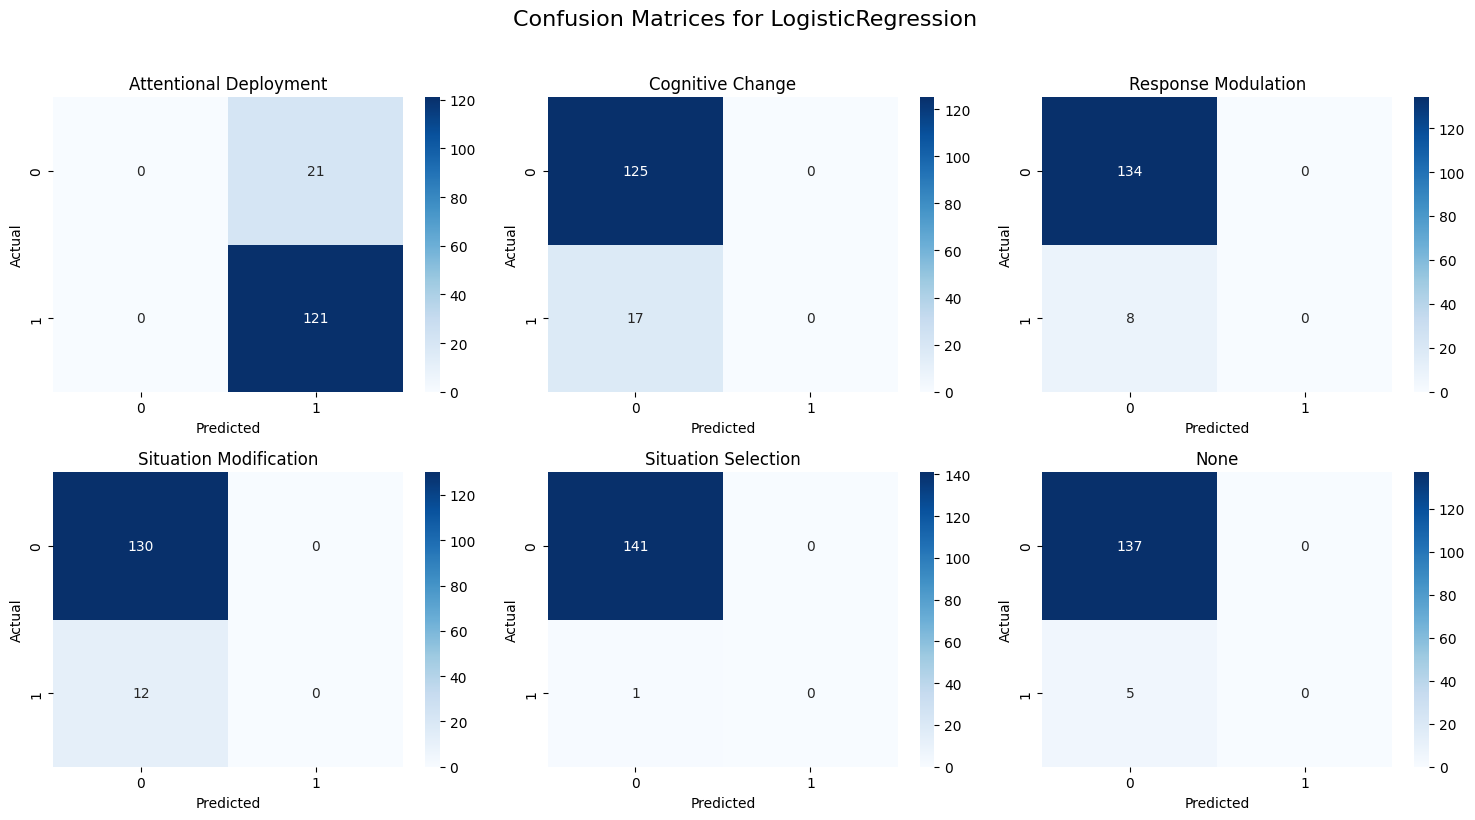


=== Evaluating RandomForest ===

DETAILED EVALUATION REPORT FOR RandomForestClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8521     0.8521     1.0000     0.9202    
Cognitive Change          0.8803     0.0000     0.0000     0.0000    
Response Modulation       0.9437     0.0000     0.0000     0.0000    
Situation Modification    0.9155     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.7394
Macro-Averaged Precision: 0.1534
Macro-Averaged Recall: 0.1534
Macro-Averaged F1-Score: 0.1534


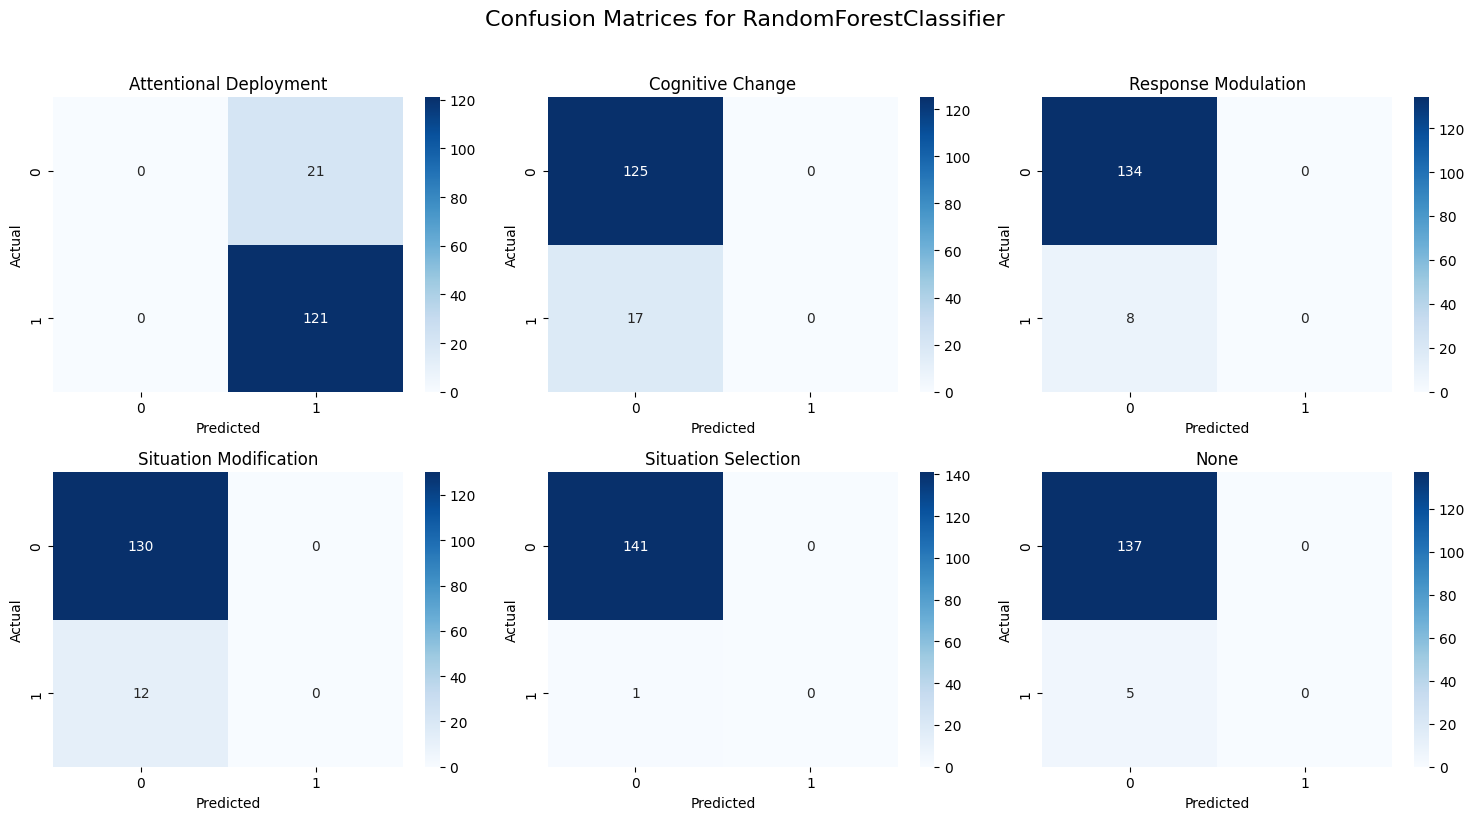


=== Evaluating SVM ===

DETAILED EVALUATION REPORT FOR SVC

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8521     0.8521     1.0000     0.9202    
Cognitive Change          0.8803     0.0000     0.0000     0.0000    
Response Modulation       0.9437     0.0000     0.0000     0.0000    
Situation Modification    0.9155     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.7394
Macro-Averaged Precision: 0.1534
Macro-Averaged Recall: 0.1534
Macro-Averaged F1-Score: 0.1534


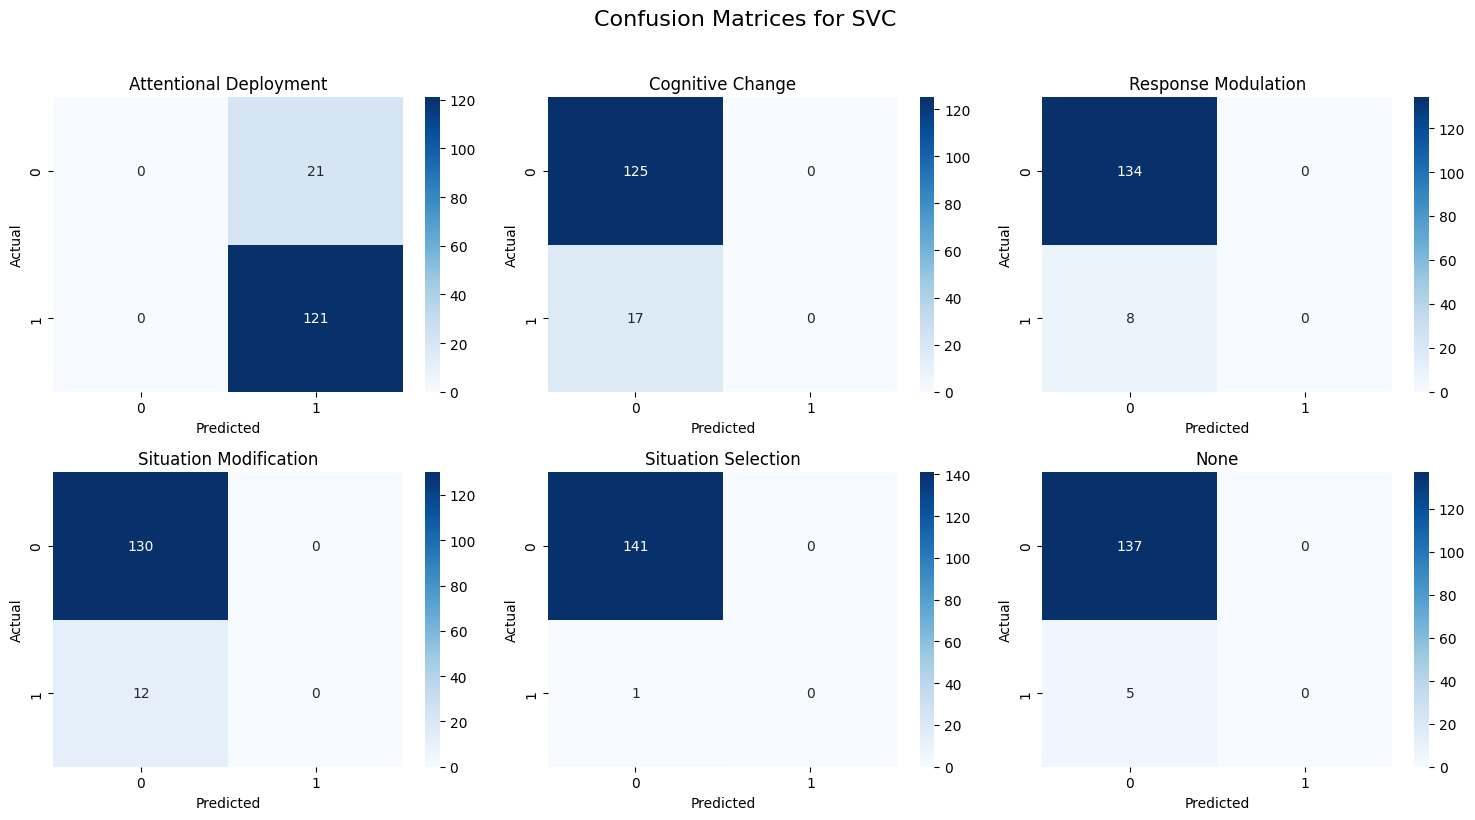


=== Evaluating AdaBoost ===

DETAILED EVALUATION REPORT FOR AdaBoostClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8521     0.8571     0.9917     0.9195    
Cognitive Change          0.8732     0.0000     0.0000     0.0000    
Response Modulation       0.9366     0.3333     0.1250     0.1818    
Situation Modification    0.9085     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.7254
Macro-Averaged Precision: 0.1836
Macro-Averaged Recall: 0.1836
Macro-Averaged F1-Score: 0.1836


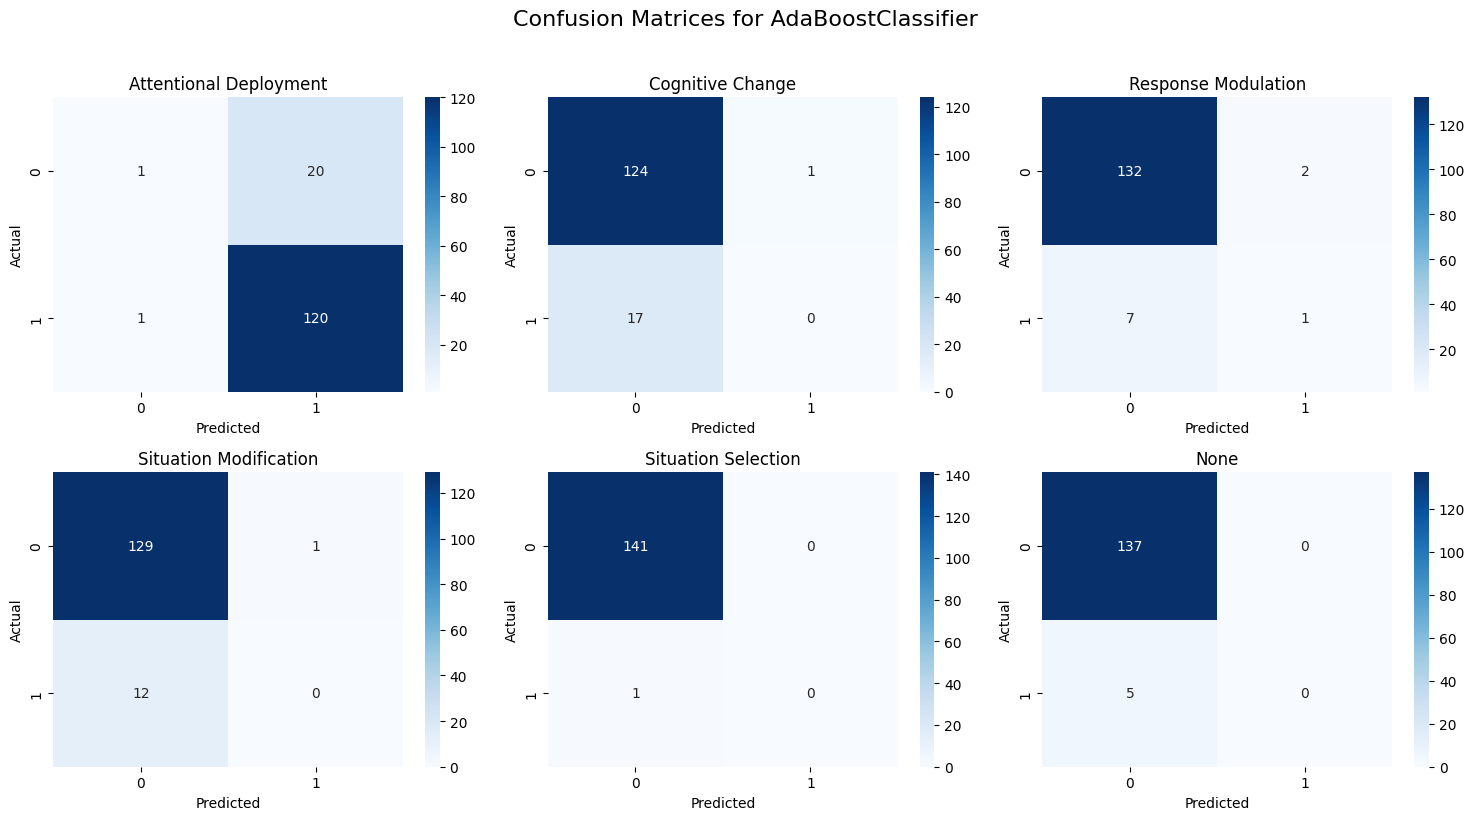


=== Evaluating NaiveBayes ===

DETAILED EVALUATION REPORT FOR MultinomialNB

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8521     0.8521     1.0000     0.9202    
Cognitive Change          0.8803     0.0000     0.0000     0.0000    
Response Modulation       0.9437     0.0000     0.0000     0.0000    
Situation Modification    0.9155     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.7394
Macro-Averaged Precision: 0.1534
Macro-Averaged Recall: 0.1534
Macro-Averaged F1-Score: 0.1534


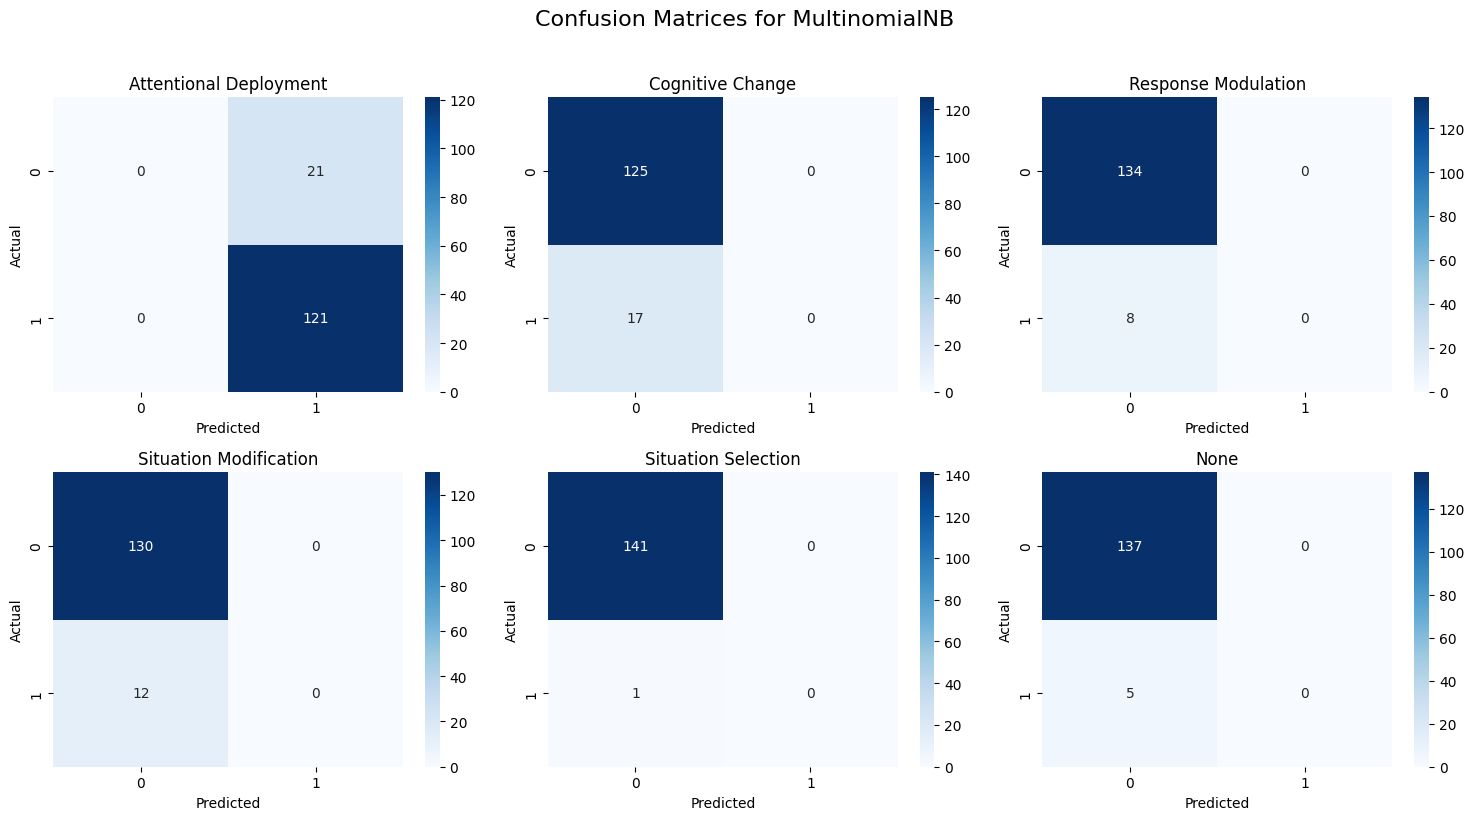


=== Evaluating KNN ===

DETAILED EVALUATION REPORT FOR KNeighborsClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8521     0.8521     1.0000     0.9202    
Cognitive Change          0.8803     0.0000     0.0000     0.0000    
Response Modulation       0.9437     0.0000     0.0000     0.0000    
Situation Modification    0.9155     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.7394
Macro-Averaged Precision: 0.1534
Macro-Averaged Recall: 0.1534
Macro-Averaged F1-Score: 0.1534


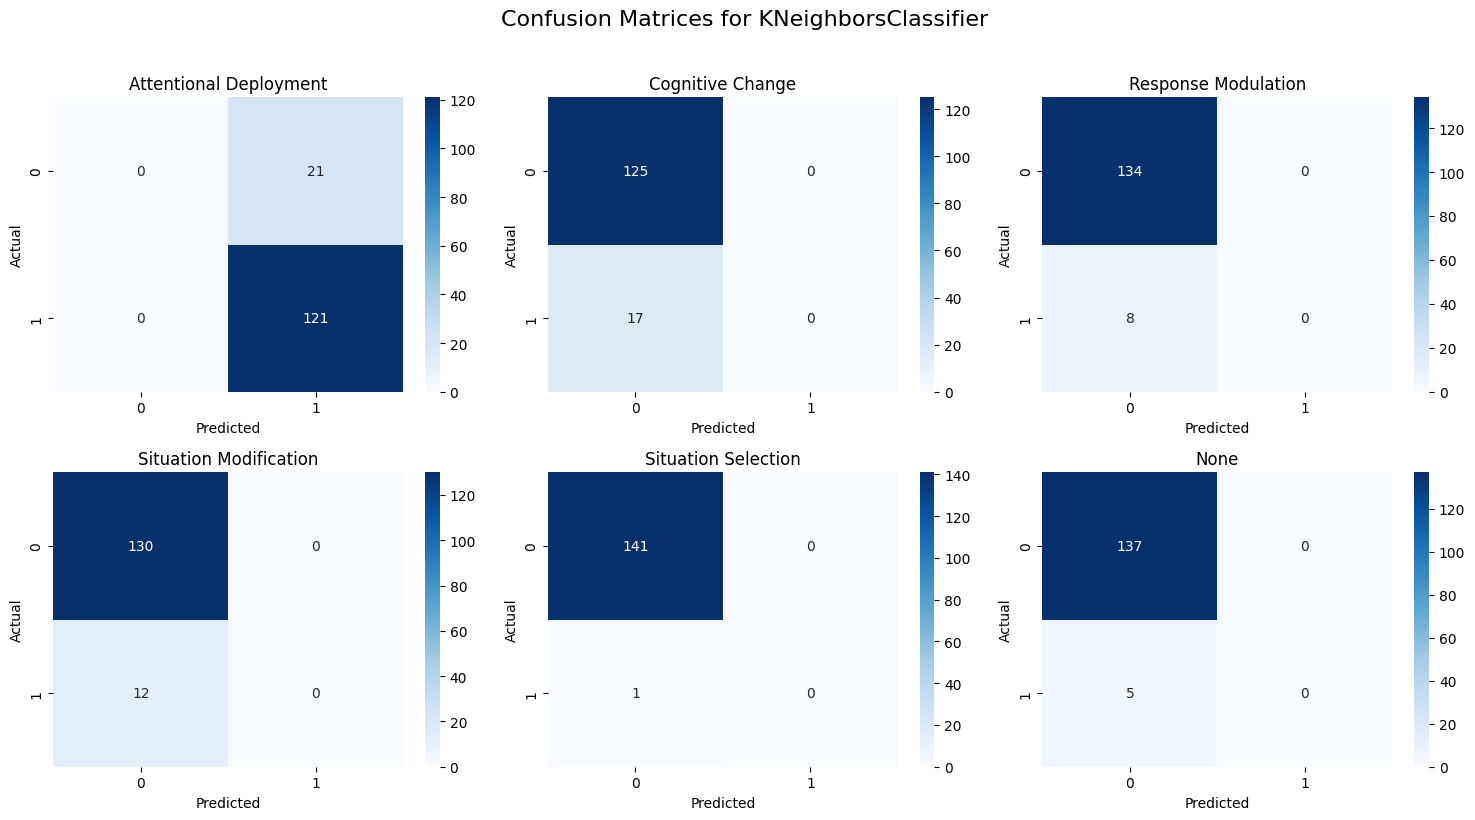


=== Evaluating DecisionTree ===

DETAILED EVALUATION REPORT FOR DecisionTreeClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.8239     0.8692     0.9339     0.9004    
Cognitive Change          0.8873     1.0000     0.0588     0.1111    
Response Modulation       0.9507     0.6000     0.3750     0.4615    
Situation Modification    0.8592     0.0000     0.0000     0.0000    
Situation Selection       0.9930     0.0000     0.0000     0.0000    
None                      0.9648     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.6620
Macro-Averaged Precision: 0.2455
Macro-Averaged Recall: 0.2455
Macro-Averaged F1-Score: 0.2455


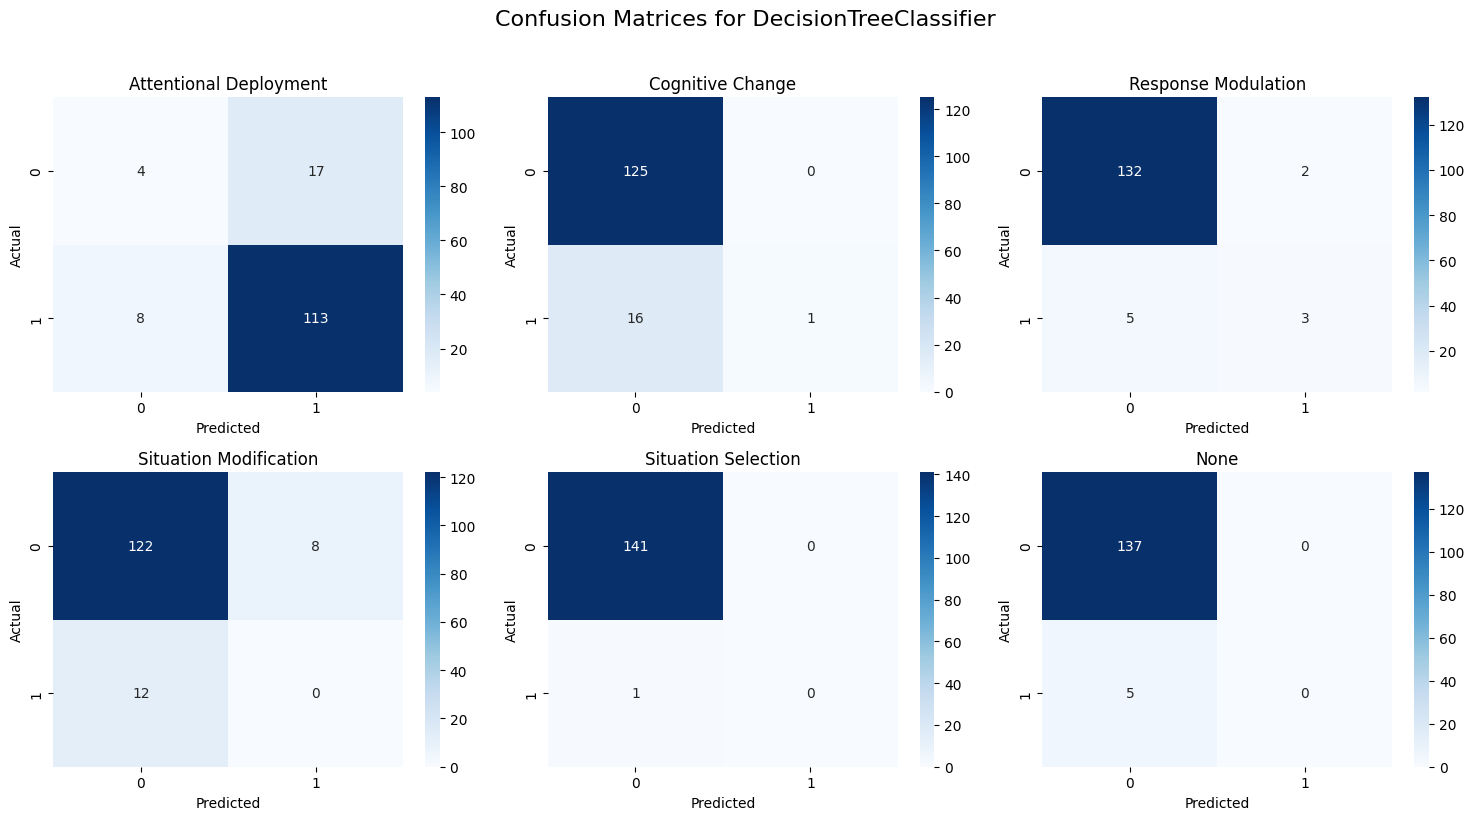


Generating overall performance visualizations...


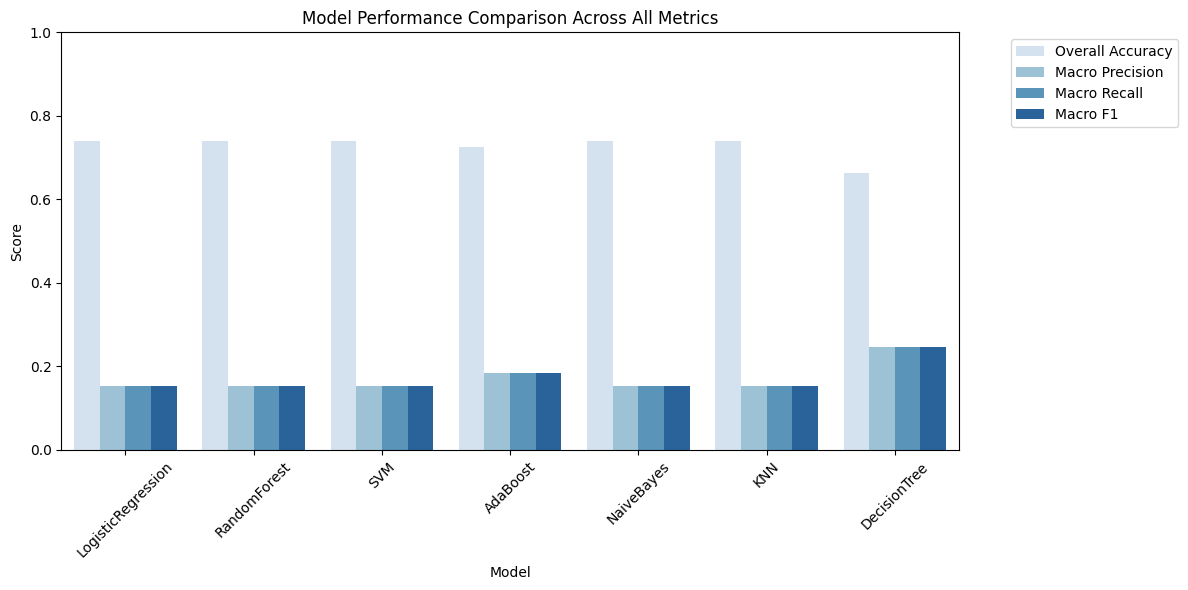


Generating per-category performance visualizations...


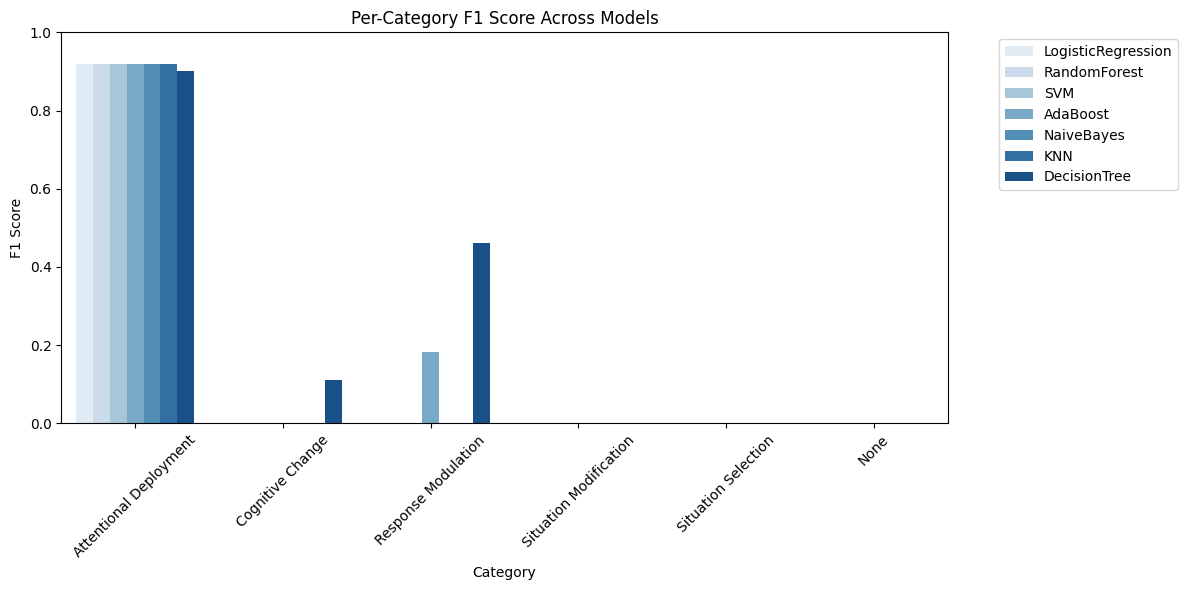

In [ ]:
def plot_per_category_model_comparison(results, categories):
    # Plot F1-scores for each model across different categories.

    # Prepare data for plotting
    metrics_data = {
        'Model': [],
        'Category': [],
        'F1 Score': []
    }

    # Populate data for each model and category
    for model_name, model_results in results.items():
        for category in categories:
            metrics_data['Model'].append(model_name)
            metrics_data['Category'].append(category)
            metrics_data['F1 Score'].append(model_results['category_f1_scores'].get(category, 0))

    # Convert data to DataFrame and plot
    df_metrics = pd.DataFrame(metrics_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_metrics, x='Category', y='F1 Score', hue='Model', palette='Blues')
    plt.title('Per-Category F1 Score Across Models')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # F1-score range
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_overall_model_comparison(results):
    # Plot overall performance metrics for all models in a grouped bar chart

    # Prepare a dictionary to hold performance metrics for each model
    metrics_data = {
        'Model': [],
        'Metric': [],
        'Score': []
    }

    # Populate the dictionary with scores for each model and metric
    for model_name, metrics in results.items():
        for metric in ['overall_accuracy', 'macro_precision', 'macro_recall', 'macro_f1']:
            metrics_data['Model'].append(model_name)
            metrics_data['Metric'].append(metric.replace('_', ' ').title())
            metrics_data['Score'].append(metrics[metric])

    df_metrics = pd.DataFrame(metrics_data)

    # Plot the grouped bar chart comparing models on various metrics
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_metrics, x='Model', y='Score', hue='Metric', palette='Blues')
    plt.title('Model Performance Comparison Across All Metrics')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def evaluate_model_across_categories(model, X, df, categories):
    # Split data into training and test sets
    X_train, X_test, df_train, df_test = train_test_split(X, df, test_size=0.3, random_state=42)

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Initialize predictions and confusion matrices
    all_predictions = np.zeros((len(X_test), len(categories)))
    all_true_labels = df_test[categories].values
    confusion_matrices = {}

    print(f"\n{'=' * 80}")
    print(f"DETAILED EVALUATION REPORT FOR {model.__class__.__name__}")
    print(f"{'=' * 80}")

    print(f"\n{'Category':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 65)

    category_f1_scores = {}

    # Evaluate performance for each category
    for idx, category in enumerate(categories):
        y_train = df_train[category]
        y_test = df_test[category]

        # Train the model and make predictions
        model.fit(X_train_vec, y_train)
        predictions = model.predict(X_test_vec)
        all_predictions[:, idx] = predictions

        # Get classification report and metrics for the category
        report = classification_report(y_test, predictions, output_dict=True)
        metrics = report['1'] if '1' in report else report['weighted avg']

        print(f"{category:<25} "
              f"{report['accuracy']:<10.4f} "
              f"{metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} "
              f"{metrics['f1-score']:<10.4f}")

        confusion_matrices[category] = confusion_matrix(y_test, predictions)
        category_f1_scores[category] = metrics['f1-score']

    print(f"\n{'-' * 80}")
    print("OVERALL MODEL PERFORMANCE")
    print(f"{'-' * 80}")

    # Calculate overall performance
    correct_predictions = np.all(all_predictions == all_true_labels, axis=1)
    overall_accuracy = np.mean(correct_predictions)

    macro_precision = np.mean([category_f1_scores[cat] for cat in categories])
    macro_recall = np.mean([category_f1_scores[cat] for cat in categories])
    macro_f1 = np.mean([category_f1_scores[cat] for cat in categories])

    print(f"\nExact Match Accuracy: {overall_accuracy:.4f}")
    print(f"Macro-Averaged Precision: {macro_precision:.4f}")
    print(f"Macro-Averaged Recall: {macro_recall:.4f}")
    print(f"Macro-Averaged F1-Score: {macro_f1:.4f}")

    # Plot confusion matrices for the model's predictions
    plot_confusion_matrices(confusion_matrices, categories, model.__class__.__name__)

    return {
        'overall_accuracy': overall_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'category_f1_scores': category_f1_scores,
        'confusion_matrices': confusion_matrices,
        'predictions': all_predictions
    }

def plot_confusion_matrices(confusion_matrices, categories, model_name):
    # Define the grid size for plotting confusion matrices
    n_categories = len(categories)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols

    # Create a figure for confusion matrices
    plt.figure(figsize=(15, 4 * n_rows))
    plt.suptitle(f'Confusion Matrices for {model_name}', fontsize=16, y=1.02)

    # Loop through each category and plot its confusion matrix
    for idx, (category, cm) in enumerate(confusion_matrices.items()):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{category}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

try:
    categories = ['Attentional Deployment', 'Cognitive Change', 'Response Modulation', 'Situation Modification', 'Situation Selection', 'None']
    df['None'] = np.where(df[categories[:-1]].sum(axis=1) == 0, 1, 0)
    X = df['text_ner']

    models = {
        "LogisticRegression": LogisticRegression(max_iter=3000),
        "RandomForest": RandomForestClassifier(random_state=42),
        "SVM": SVC(kernel="linear", probability=True),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "NaiveBayes": MultinomialNB(),
        "KNN": KNeighborsClassifier(n_neighbors=15),
        "DecisionTree": DecisionTreeClassifier(),
    }

    results = {}
    for model_name, model in models.items():
        print(f"\n=== Evaluating {model_name} ===")
        evaluation_results = evaluate_model_across_categories(model, X, df, categories)
        results[model_name] = evaluation_results

    print("\nGenerating overall performance visualizations...")
    plot_overall_model_comparison(results)

    print("\nGenerating per-category performance visualizations...")
    plot_per_category_model_comparison(results, categories)

except Exception as e:
    print(f"Error in main script: {e}")
    traceback.print_exc()
